<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data = data.resample('1H').sum()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Имеются данные о количестве заказов объемом 4416 строк с марта по конец августа 2018 г. Пропусков нет, переходим к анализу.

## Анализ

Чтобы лучше понимать временной ряд, посмотрим на его график и выделим тренд.

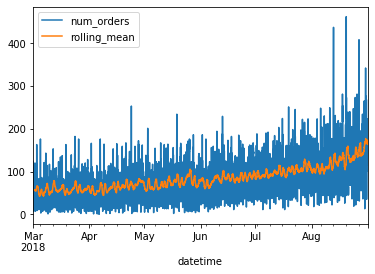

In [6]:
data['rolling_mean'] = data.rolling(24).mean()
data.plot()

Временной ряд нестационарный, количество продаж имеет тенденцию к увеличению.

In [7]:
data = data.drop('rolling_mean', axis=1)

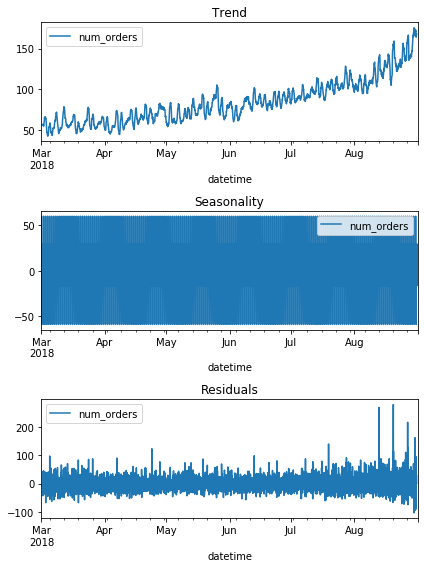

In [8]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal .plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid .plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сезонная компонента сливается, развернем масштаб.

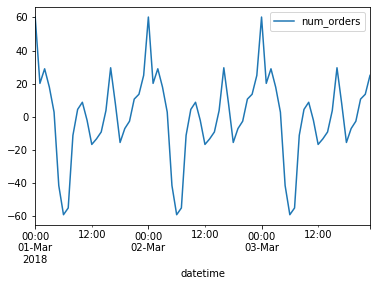

In [9]:
decomposed.seasonal.loc['2018-03-01':'2018-03-03'].plot()

## Обучение

Создадим новые признаки - месяц, день, день недели, час, отстающие значения и скользящее среднее (мы его уже добавили, но в данном случае предусмотрим возможность вариации ширины окна).

In [10]:
def make_features(data, max_lag, rolling_mean_size):
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


Добавим признаки - 7 временных лагов и скользящее среднее за 24 часа.

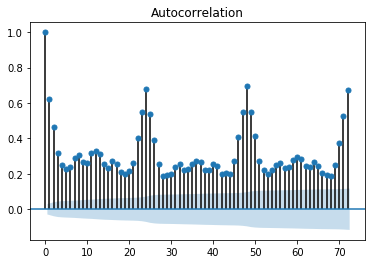

In [11]:
sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=72);

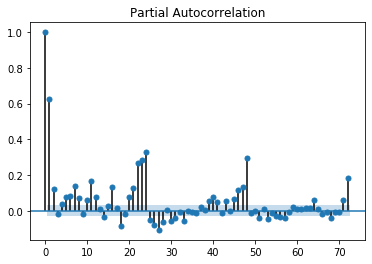

In [12]:
sm.graphics.tsa.plot_pacf(data, lags=72);

In [13]:
make_features(data, 24, 48)

Для обучения и тестирования моделей прогнозирования продаж отделим тестовую выборку размером 10% от исходных данных.

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Попробуем модель линейной регрессии.

In [17]:
model = LinearRegression()
model.fit(features_train,target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
(mean_squared_error(target_train, 
                   model.predict(features_train)))**.5

25.86160749961759

In [19]:
target_train.mean()

78.51681100356598

Ошибка (СКО) приличная, 25 авто туда-сюда при средних продажах 78 машин. Попробуем другую модель - случайный лес при градиентном бустинге.

In [20]:
model_1 = LGBMRegressor()

In [21]:
%%time
model_1.fit(features_train,target_train)

CPU times: user 51.9 s, sys: 377 ms, total: 52.3 s
Wall time: 53 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
(mean_squared_error(target_train, 
                   model_1.predict(features_train)))**.5

12.195167188450705

Ошибка модели случайного леса с гиперпараметрами, найденными с помощью градиентного бустинга в два раза меньше, чем у линейной регрессии. Перейдем к тестированию.

## Тестирование

In [23]:
(mean_squared_error(target_test, 
                   model.predict(features_test)))**.5

45.07171658634129

Ошибка для линейной регрессии на тестовых данных большая - 45 автомобилей. Посмотрим на вторую модель.

In [24]:
(mean_squared_error(target_test, 
                   model_1.predict(features_test)))**.5

41.74174475307333

Ошибка меньше, но все равно приличная. Посмотрим на сам целевой признак в тестовых данных.

In [25]:
target_test.describe()

count    442.000000
mean     139.556561
std       58.615955
min       13.000000
25%      104.000000
50%      135.000000
75%      173.000000
max      462.000000
Name: num_orders, dtype: float64

Средний объем продаж для тестовых данных- около 140 автомобилей в час. Ошибка модели - 42 автомобиля/час. Наверное, это неплохо. 

P.S.  
Тренд временного ряда до начала августа (первые 5 месяцев) похож на колебания вокруг линейной функции, а в конце имеет тенденцию к нелинейному росту. Может, в этом причина большой ошибки?